# Gutenberg_Project

In [30]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

import glob
import re
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import pickle

from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import datetime
from sklearn import feature_selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


In [31]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import Image
from keras.utils import np_utils

In [43]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ymass\AppData\Roaming\nltk_data...


True

## 1. Data preparation and pre-processing using Spacy and other methods (nltk)

In [33]:
#Define a function to read the entire content of a book
def read_book(title_path): 
    #Read a book and return it as a string
    with open(title_path,"r",encoding = "utf8") as current_file:            
        text = current_file.read()
        text = text.replace("\n", " ")
        text = text.split(". ")
    return text 

In [34]:
#Load all titles of books
book_files = glob.glob('gutenberg_project_book/*.txt')
book_files

['gutenberg_project_book\\Alice_Adventures_in_Wonderland_by_Lewis Carroll.txt',
 'gutenberg_project_book\\Ancient_and_Modern_Physics_by_Thomas E. Willson.txt',
 'gutenberg_project_book\\Astronomy_for_Amateurs_by_Camille Flammarion.txt',
 'gutenberg_project_book\\Birds_in_Town_and_Village_by_W. H. Hudson.txt',
 'gutenberg_project_book\\Cattle_and_Their_Diseases_by_Robert Jennings.txt',
 'gutenberg_project_book\\Cave_Regions_of_the_Ozarks_and_Black_Hills_by_Luella Agnes Owen.txt',
 'gutenberg_project_book\\On_the_Origin_of_Species_by_Charles Darwin.txt',
 'gutenberg_project_book\\The_Chemistry_of_Hat_Manufacturing_by_Watson Smith.txt',
 'gutenberg_project_book\\The_English_Constitution_by_Walter Bagehot.txt',
 'gutenberg_project_book\\The_Kybalion_by_Three Initiates.txt']

In [35]:
#Get the corresponding author list
author_list = []
for i in range(len(book_files)):
    author_name = book_files[i].split('by_')[1].split('.txt')[0]
    author_list.append(author_name)
    
author_list

['Lewis Carroll',
 'Thomas E. Willson',
 'Camille Flammarion',
 'W. H. Hudson',
 'Robert Jennings',
 'Luella Agnes Owen',
 'Charles Darwin',
 'Watson Smith',
 'Walter Bagehot',
 'Three Initiates']

In [36]:
#Create dataframe for texts of all books, authors and respective labels
text_data_list = []
i = 0
for filename in book_files:
    book = read_book(filename)[:2000]
    book_df = pd.DataFrame({'text': book, 'author_name': author_list[i], 'author_class':i})
    text_data_list.append(book_df)
    i += 1

text_df = pd.concat(text_data_list, ignore_index = True)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15350 entries, 0 to 15349
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          15350 non-null  object
 1   author_name   15350 non-null  object
 2   author_class  15350 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 359.9+ KB


In [37]:
#Show the first 10 rows
text_df.head(10)

,text,author_name,author_class
0,﻿ I,Lewis Carroll,0
1,Down the Rabbit-Hole Alice was beginning to ...,Lewis Carroll,0
2,There was nothing so _very_ remarkable in tha...,Lewis Carroll,0
3,"In another moment down went Alice after it, n...",Lewis Carroll,0
4,The rabbit-hole went straight on like a tunne...,Lewis Carroll,0
5,"Either the well was very deep, or she fell ve...",Lewis Carroll,0
6,"First, she tried to look down and make out wha...",Lewis Carroll,0
7,She took down a jar from one of the shelves as...,Lewis Carroll,0
8,"“Well!” thought Alice to herself, “after such...",Lewis Carroll,0
9,Would the fall _never_ come to an end? “I wond...,Lewis Carroll,0


In [38]:
#Using NLTK in this project to preprocess texts instead of Spacy - download list of stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))

In [39]:
#Define a function to preprocess raw texts by removing punctuations & characters, stopwords, lemmatisation
def clean_text(text, stopwords):
    le=WordNetLemmatizer()
    processed_text = re.sub(r"[^a-z ]","", text.lower())
    word_tokens=word_tokenize(processed_text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stopwords and len(w) > 2]
    # if a sentence is only one or two words long, the benefit for the training later is very small
    if len(tokens) > 2:
        cleaned_text=" ".join(tokens)
        return cleaned_text

In [44]:
#Use the above function to clean texts
text_df['clean_text'] = text_df['text'].apply(lambda x: clean_text(x, stop_words))
text_df.head(10)

,text,author_name,author_class,clean_text
0,﻿ I,Lewis Carroll,0,None
1,Down the Rabbit-Hole Alice was beginning to ...,Lewis Carroll,0,rabbithole alice beginning get tired sitting s...
2,There was nothing so _very_ remarkable in tha...,Lewis Carroll,0,nothing remarkable alice think much way hear r...
3,"In another moment down went Alice after it, n...",Lewis Carroll,0,another moment went alice never considering wo...
4,The rabbit-hole went straight on like a tunne...,Lewis Carroll,0,rabbithole went straight like tunnel way dippe...
5,"Either the well was very deep, or she fell ve...",Lewis Carroll,0,either well deep fell slowly plenty time went ...
6,"First, she tried to look down and make out wha...",Lewis Carroll,0,first tried look make coming dark see anything...
7,She took down a jar from one of the shelves as...,Lewis Carroll,0,took jar one shelf passed labelled orange marm...
8,"“Well!” thought Alice to herself, “after such...",Lewis Carroll,0,well thought alice fall shall think nothing tu...
9,Would the fall _never_ come to an end? “I wond...,Lewis Carroll,0,would fall never come end wonder many mile ive...


In [45]:
#Remove the original column of raw texts
processed_df = text_df[['clean_text','author_name','author_class']]
processed_df.head()

,clean_text,author_name,author_class
0,None,Lewis Carroll,0
1,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0
2,nothing remarkable alice think much way hear r...,Lewis Carroll,0
3,another moment went alice never considering wo...,Lewis Carroll,0
4,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0


In [46]:
#Check null values
processed_df.isnull().sum()

clean_text      1028
author_name        0
author_class       0
dtype: int64

In [47]:
#Remove all null values
processed_df = processed_df.dropna().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14322 entries, 0 to 14321
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_text    14322 non-null  object
 1   author_name   14322 non-null  object
 2   author_class  14322 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 335.8+ KB


In [48]:
#Remove duplicated rows
processed_df = processed_df.drop_duplicates().reset_index().drop('index', axis=1)
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14305 entries, 0 to 14304
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   clean_text    14305 non-null  object
 1   author_name   14305 non-null  object
 2   author_class  14305 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 335.4+ KB


In [49]:
#Show the last 10 rows
processed_df.tail(10)

,clean_text,author_name,author_class
14295,understands well road masterythe kybalion,Three Initiates,9
14296,conclusion let call attention hermetic axiom t...,Three Initiates,9
14297,axiom hermetists teach great work influencing ...,Three Initiates,9
14298,universe wholly mental follows may ruled menta...,Three Initiates,9
14299,truth found explanation phenomenon manifestati...,Three Initiates,9
14300,back teaching various cult school remains ever...,Three Initiates,9
14301,universe mental substantial nature follows men...,Three Initiates,9
14302,universe mental mind must highest power affect...,Three Initiates,9
14303,understood socalled miracle wonderworkings see...,Three Initiates,9
14304,mind universe mentalthe kybalion,Three Initiates,9


In [50]:
#Make another copy for exploratory data exploration later
clean_data = processed_df.copy(deep=True)

## 2. Perform data exploration

### * Sentence-level analysis

Max length: 1028, Min length: 12, Average Length :  111.0


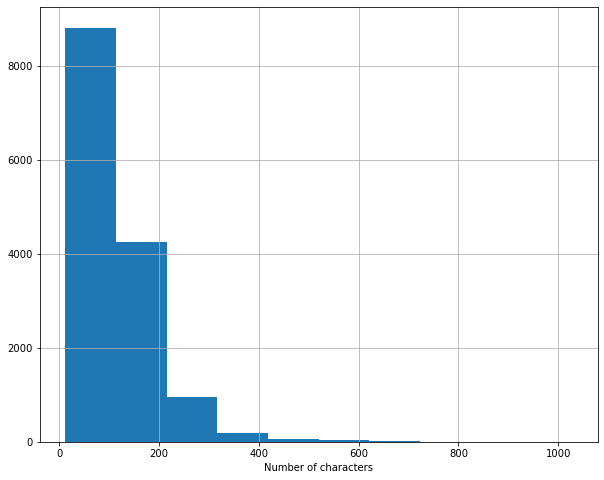

In [51]:
#Create a new column 'sentence_len'
clean_data['sentence_len'] = clean_data['clean_text'].str.len()
print('Max length: {}, Min length: {}, Average Length :  {}'.format(max(clean_data['sentence_len']),
                                            min(clean_data['sentence_len']), round(clean_data['sentence_len'].mean(), 0)))

#Visualize number of characters in all rows (i.e. sentences)
plt.figure(figsize = (10,8))
clean_data['sentence_len'].hist()
plt.xlabel('Number of characters')
plt.show()

### Comments:
- We can see that sentences range from 12 to 1028 characters.  
- Majority of sentences are approximately between 12 and 200 characters.  

### * Word-level analysis 

Max_word_count: 161, Min_word_count: 3, Average_word_count:  15.0


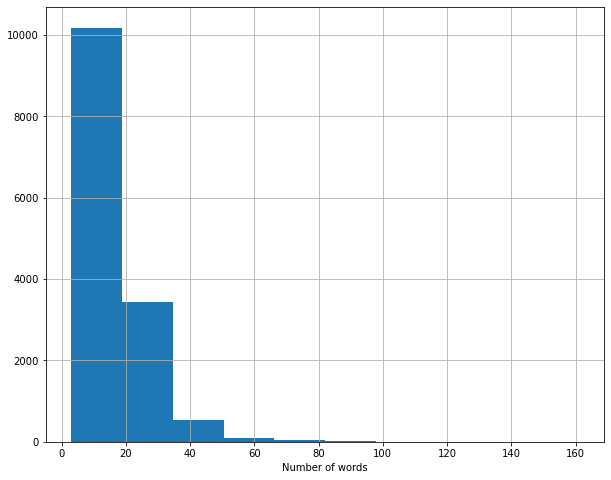

In [52]:
#Create a new column 'word_count'
clean_data['word_count'] = clean_data['clean_text'].str.split().map(lambda x: len(x))
print('Max_word_count: {}, Min_word_count: {}, Average_word_count:  {}'.format(max(clean_data['word_count']),
                                        min(clean_data['word_count']), round(clean_data['word_count'].mean(), 0)))

#Visualize number of words in all sentences
plt.figure(figsize = (10,8))
clean_data['word_count'].hist()
plt.xlabel('Number of words')
plt.show()

### Comments:
- It is clear that number of words in each sentence range from 3 to 161.  
- Most of sentences have a total word count of 3 to 34 as shown in the above chart.  

In [53]:
#Determine the most common words (which is the highest frequencies)
#Create list of words for the entire document in the column 'clean_text'
all_text = ' '.join(t for t in clean_data['clean_text'])
words_list = all_text.split()

#Create a dictionary of words
word_freq = {}
for word in set(words_list):
    word_freq[word] = words_list.count(word)

#Creating dataframe of words
df_word = pd.DataFrame(word_freq.items(),columns=['word','count'])
df_word['word_len'] = df_word['word'].map(lambda x: len(x))

#Sorting values 
df_word = df_word.sort_values('count', ascending=False).reset_index(drop=True)
df_word.head(10)

,word,count,word_len
0,one,1861,3
1,would,1311,5
2,may,1084,3
3,time,883,4
4,specie,805,6
5,two,800,3
6,great,786,5
7,said,727,4
8,bird,704,4
9,many,683,4


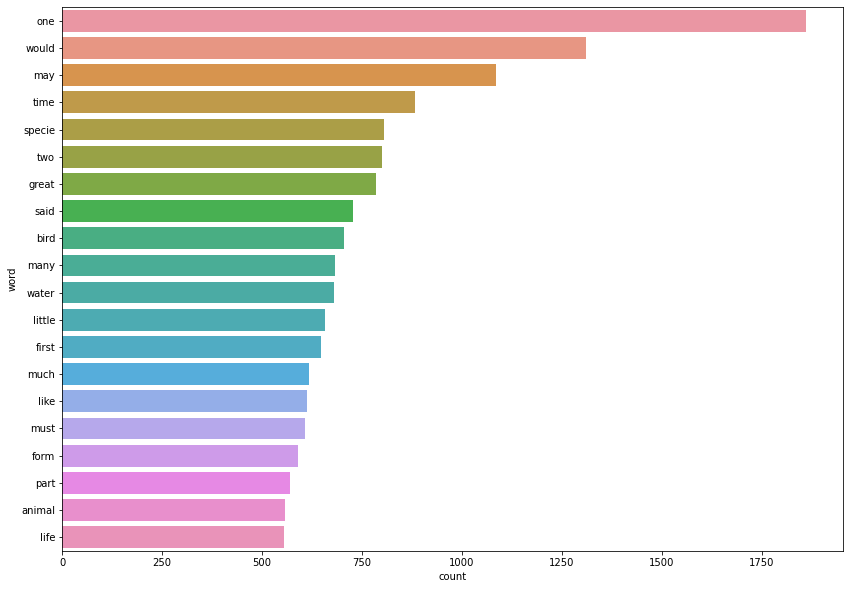

In [54]:
#Display the 20 most common words
plt.figure(figsize = (14,10))
sb.barplot(df_word['count'][:20],df_word['word'][:20])
plt.show()

In [154]:
#WordCloud to determine which words representing the text corpus of the whole document
#Generate word cloud for all texts
import PIL
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from wordcloud import STOPWORDS, ImageColorGenerator
word_cloud = WordCloud(background_color = 'black', max_words=200, max_font_size=150,
                      width = 1600, height = 800, random_state = 42).generate(all_text)
#Show the word cloud
plt.figure(figsize=(14,16))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show

ValueError: Only supported for TrueType fonts

In [141]:
import PIL

### Comments:
- We can see obviously that the most common words such as 'one','may','time','great' so on with the highest frequencies (number of counts) in the bar chart will appear in the biggest size in the word cloud.

### * Sentiment Analysis

In [58]:
#Define a function to compute 'polarity score'
def polarity_score(text):
    return TextBlob(text).sentiment.polarity

#Define a function to determine types of polarity
def sentiment(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

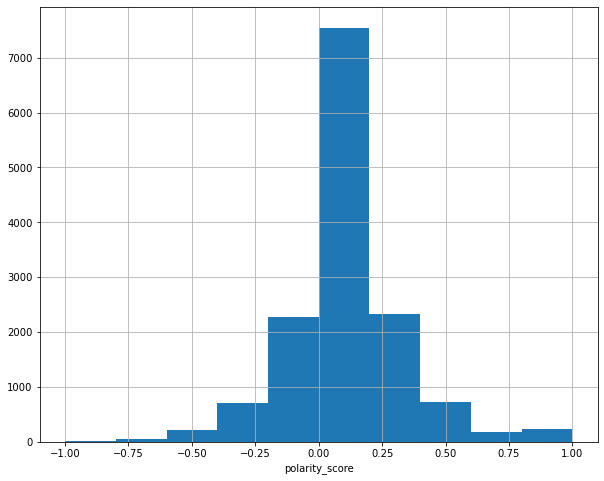

In [59]:
#Determine polarity score of the entire document
#Create a new column 'polarity score'
clean_data['polarity_score'] = clean_data['clean_text'].apply(lambda x : polarity_score(x))

#Visualize
plt.figure(figsize = (10,8))
clean_data['polarity_score'].hist()
plt.xlabel('polarity_score')
plt.show()

### Comments:
You can see that the polarity score mainly ranges between 0.00 and 0.20. This means that the majority of texts are neutral.  

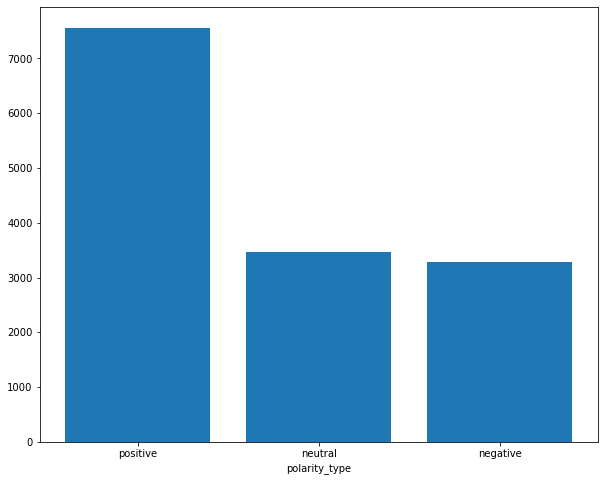

In [60]:
#Deeper classifying the texts as negative, positive and neutral based on the scores
#Create a new column 'polarity type'
clean_data['polarity_type'] = clean_data['polarity_score'].map(lambda x: sentiment(x))

#Visualize
plt.figure(figsize = (10,8))
plt.bar(clean_data.polarity_type.value_counts().index, clean_data.polarity_type.value_counts())
plt.xlabel('polarity_type')
plt.show()

### Comments:
It is clearly that majority of sentences are 'neutral' and 'positive', which is more than twice as many as 'negative'.  

## 3. Using Bag of Word, apply supervised models such as Naive Bayes, Logistic Regression, Decision Tree, Random Forest, KNN, SVM and Gradient Boosting, including GridSearchCV.
To build a classification model, some below algorithms will be used to compare one another and select the best one with highest AUC or Gini:
- Logistic Regression
- Naive Bayes
- Decision Tree
- Random Forest
- Gradient Boosting Tree

In [61]:
#Show the clean data for quick reference
clean_data.head()

,clean_text,author_name,author_class,sentence_len,word_count,polarity_score,polarity_type
0,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0,348,50,-0.135714,negative
1,nothing remarkable alice think much way hear r...,Lewis Carroll,0,377,54,0.194898,positive
2,another moment went alice never considering wo...,Lewis Carroll,0,53,8,0.000000,neutral
3,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0,117,17,0.066667,positive
4,either well deep fell slowly plenty time went ...,Lewis Carroll,0,75,13,-0.100000,negative


In [62]:
#Separate 'source' and 'target'
source = clean_data['clean_text']
target = clean_data['author_class']

In [63]:
#Create array for source data
source_text = np.array(source)
source_text[:10]

array(['rabbithole alice beginning get tired sitting sister bank nothing twice peeped book sister reading picture conversation use book thought alice without picture conversation considering mind well could hot day made feel sleepy stupid whether pleasure making daisychain would worth trouble getting picking daisy suddenly white rabbit pink eye ran close',
       'nothing remarkable alice think much way hear rabbit say dear dear shall late thought afterwards occurred ought wondered time seemed quite natural rabbit actually took watch waistcoatpocket looked hurried alice started foot flashed across mind never seen rabbit either waistcoatpocket watch take burning curiosity ran across field fortunately time see pop large rabbithole hedge',
       'another moment went alice never considering world get',
       'rabbithole went straight like tunnel way dipped suddenly suddenly alice moment think stopping found falling deep well',
       'either well deep fell slowly plenty time went look wo

In [64]:
#Create an array for target data
y = np.array(target)

In [65]:
#Create a CountVectorizer instance
count_vec = CountVectorizer(stop_words = 'english', max_features=2000)

In [66]:
#Fit the full data
count_vec.fit(source_text)

CountVectorizer(max_features=2000, stop_words='english')

In [67]:
#Transform source text array into a sparse numeric matrix
bags_of_words = count_vec.transform(source_text)
bags_of_words

<14305x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 125986 stored elements in Compressed Sparse Row format>

In [68]:
#Then convert it into a numeric array X
X = bags_of_words.toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [69]:
# Tính độ chính xác model theo: 
# Logistic, Naive Bayes, RandomForestClassifier, DecisionTreeClassifier, GradientBoostingClassifier
def compute_models(input_source, output_target):
    
    X_train, X_test, y_train, y_test = train_test_split(input_source, output_target, test_size = 0.20, random_state = 42)
    
    models = [
            LogisticRegression(),
            DecisionTreeClassifier(),
            RandomForestClassifier(n_estimators=15), #since dataset is quite large, choose small number of trees = 15
            GradientBoostingClassifier(n_estimators=15),
            MultinomialNB()
        ]

    CV = 3
    entries =[]
    
    for model in models:
        scores_train = []
        scores_test = []
        abs_scores = []
        times = []
        gini_val = []

        for i in range(CV):
            t1 = datetime.datetime.now()
            model_name = model.__class__.__name__
            model.fit(X_train,y_train)
            t2 = datetime.datetime.now()
            d = round((t2-t1).microseconds/1000,1)
            score_train = model.score(X_train,y_train)
            score_test = model.score(X_test,y_test)
            abs_score = abs(score_train - score_test)
            y_prob = model.predict_proba(X_test)
            auc_val = roc_auc_score(y_test, y_prob, multi_class='ovr')
            gini = 2 * auc_val - 1

            scores_train.append(score_train)
            scores_test.append(score_test)
            abs_scores.append(abs_score)
            gini_val.append(gini)
            times.append(d)

        print('Scores of test dataset:')
        print(model.__class__.__name__, scores_test)
        entries.append([model_name,np.array(scores_train).mean(),
                                np.array(scores_test).mean(), np.array(abs_scores).mean(),
                                np.array(gini_val).mean(), np.array(times).mean()])

      
    cv_df = pd.DataFrame(entries, columns=['model_name','score_train_mean',
                                   'score_test_mean','abs|score|','gini_mean','time_mean'])
    return cv_df


In [70]:
#Compute accuracies for all algorithms
cv_df = compute_models(X,y)

Scores of test dataset:
LogisticRegression [0.7934288710241174, 0.7934288710241174, 0.7934288710241174]
Scores of test dataset:
DecisionTreeClassifier [0.6413841314225796, 0.6438308283816847, 0.6494232785739252]
Scores of test dataset:
RandomForestClassifier [0.7098916462775253, 0.7095421181405103, 0.7042991960852849]
Scores of test dataset:
GradientBoostingClassifier [0.6060817895840616, 0.6060817895840616, 0.6064313177210765]
Scores of test dataset:
MultinomialNB [0.823138762670395, 0.823138762670395, 0.823138762670395]


In [71]:
#compare all algorithms using accuracy, gini and computation time
cv_df

,model_name,score_train_mean,score_test_mean,abs|score|,gini_mean,time_mean
0,LogisticRegression,0.954037,0.793429,0.160608,0.951201,622.066667
1,DecisionTreeClassifier,0.994408,0.644879,0.349528,0.630132,563.000000
2,RandomForestClassifier,0.990446,0.707911,0.282535,0.866747,693.533333
3,GradientBoostingClassifier,0.627403,0.606198,0.021205,0.793010,368.800000
4,MultinomialNB,0.873558,0.823139,0.050419,0.960002,331.033333


### Comments:
We can see that model 'MultinomialNB' has the highest Gini value (0.96) with the shortest time compared to the other models. Therefore, we will choose this model to compute later.

In [72]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [73]:
#We use the algorithm Multinomial Naive Bayes to build model
multi_nb_instance = MultinomialNB()

In [74]:
#Fit the model with train dataset
multi_nb_model = multi_nb_instance.fit(X_train_c, y_train_c)

In [75]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', multi_nb_model.score(X_train_c, y_train_c))
print('R2 score of test dataset: ', multi_nb_model.score(X_test_c, y_test_c))

R2 score of train dataset:  0.873558196434813
R2 score of test dataset:  0.823138762670395


In [76]:
#Compute the prediction based on 'X_test'
y_pred_c = multi_nb_model.predict(X_test_c)

In [77]:
#Compute accuracy and AUC of the model
accuracy_c = accuracy_score(y_test_c, y_pred_c)
y_prob_c = multi_nb_model.predict_proba(X_test_c)
auc_c = roc_auc_score(y_test_c, y_prob_c, multi_class = 'ovr')
print('Accuracy of the model is:', round(accuracy_c,2))
print("Auc of the model is:", round(auc_c,2))

Accuracy of the model is: 0.82
Auc of the model is: 0.98


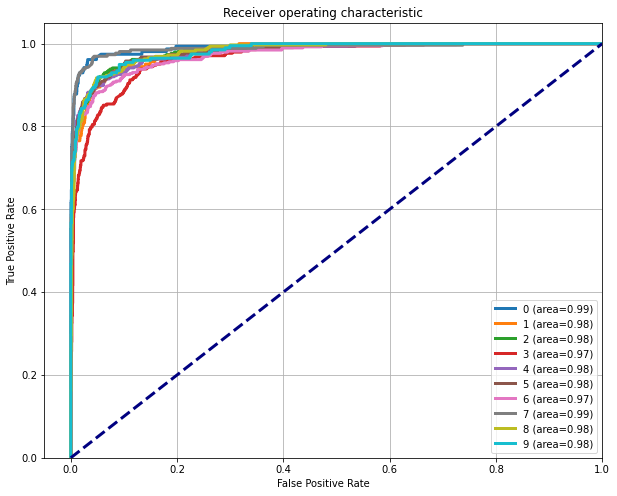

In [78]:
# Plot ROC
fig, ax = plt.subplots(figsize=(10,8))
classes = np.unique(y_test_c)  #or can use y_train_c
y_test_c_array = pd.get_dummies(y_test_c, drop_first = False).values
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_c_array[:,i], y_prob_c[:,i])
    ax.plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
    
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate',
                                    ylabel="True Positive Rate", title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)
plt.show()

In [79]:
#Print confusion matrix
confusion_matrix(y_test_c, y_pred_c)

array([[142,   0,   2,   6,   0,   2,   0,   0,   4,   0],
       [  1, 122,  12,   2,   1,   1,   3,   2,   5,  13],
       [  3,   3, 275,  10,   6,  14,   8,   2,  11,   9],
       [ 19,   0,   7, 258,   6,   6,  25,   2,  15,   5],
       [  4,   1,   5,   9, 310,   4,  24,   9,   6,   3],
       [  8,   1,   4,  15,   2, 255,   6,   4,  12,   2],
       [  1,   2,   4,  16,   9,   7, 326,   3,   8,  12],
       [  0,   3,   4,   3,   5,   3,   3, 235,   4,   2],
       [  5,   2,   4,  13,   7,   8,   6,   1, 269,  11],
       [  1,  10,   3,   4,   2,   2,   4,   0,  10, 163]], dtype=int64)

In [80]:
#Print classification report
print(classification_report(y_test_c, y_pred_c, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.77      0.91      0.84       156
 Thomas E. Willson       0.85      0.75      0.80       162
Camille Flammarion       0.86      0.81      0.83       341
      W. H. Hudson       0.77      0.75      0.76       343
   Robert Jennings       0.89      0.83      0.86       375
 Luella Agnes Owen       0.84      0.83      0.83       309
    Charles Darwin       0.80      0.84      0.82       388
      Watson Smith       0.91      0.90      0.90       262
    Walter Bagehot       0.78      0.83      0.80       326
   Three Initiates       0.74      0.82      0.78       199

          accuracy                           0.82      2861
         macro avg       0.82      0.83      0.82      2861
      weighted avg       0.83      0.82      0.82      2861



In [81]:
#Save the model with tfidf technique
pickle.dump(multi_nb_model, open("NLP_model/bow_multinb_model.pickle","wb"))

### Comments:
- With the Bags-of-Words technique, the model MultinomialNB obtains good performance. The model is neither overfitting nor underfitting.  
- The model achieves good results, which has accuracy of 0.82 and AUC value of 0.98.

## 4. Similar to 3., but using TF-IDF

In [82]:
#Create a Tf-idf Vectorizer instance
tfidf_vec = TfidfVectorizer(stop_words = 'english', max_features=2000)

In [83]:
#Fit the full data
tfidf_vec.fit(source_text)

TfidfVectorizer(max_features=2000, stop_words='english')

In [84]:
#Transform source text array into a sparse numeric matrix
tfidf_matrix = tfidf_vec.transform(source_text)
tfidf_matrix

<14305x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 125986 stored elements in Compressed Sparse Row format>

In [85]:
#Then convert it into a numeric array X
X = tfidf_matrix.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [87]:
#We use the algorithm Multinomial Naive Bayes to build model
tfidf_multi_nb = MultinomialNB()

In [88]:
#Fit the model with train dataset
tfidf_multinb_model = tfidf_multi_nb.fit(X_train_t, y_train_t)

In [89]:
#We use R2 score to check whether the model is overfitting or underfitting
print('R2 score of train dataset: ', tfidf_multinb_model.score(X_train_t, y_train_t))
print('R2 score of test dataset: ', tfidf_multinb_model.score(X_test_t, y_test_t))

R2 score of train dataset:  0.8719853198182453
R2 score of test dataset:  0.8189444250262146


In [90]:
#Compute the prediction
y_pred_t = tfidf_multinb_model.predict(X_test_t)

In [91]:
#Compute accuracy and AUC of the model
accuracy_t = accuracy_score(y_test_t, y_pred_t)
y_prob_t = tfidf_multinb_model.predict_proba(X_test_t)
auc_t = roc_auc_score(y_test_t, y_prob_t, multi_class = 'ovr')
gini_t = 2 * auc_t - 1
print('Accuracy of the model after using TF-IDF is:', round(accuracy_t,2))
print("Auc of the model after using TF-IDF is:", round(auc_t,2))
print("Gini of the model after using TF-IDF is:", round(gini_t,2))

Accuracy of the model after using TF-IDF is: 0.82
Auc of the model after using TF-IDF is: 0.98
Gini of the model after using TF-IDF is: 0.96


In [92]:
#Print confusion matrix
confusion_matrix(y_test_t, y_pred_t)

array([[129,   0,   2,  13,   1,   4,   0,   0,   7,   0],
       [  0, 100,  23,   3,   2,   1,   4,   4,   9,  16],
       [  1,   0, 279,  11,  10,   9,   9,   2,  12,   8],
       [  6,   0,   9, 260,   8,   6,  32,   2,  19,   1],
       [  3,   0,   5,   5, 314,   5,  25,   7,   8,   3],
       [  3,   1,   4,  15,   4, 255,   5,   4,  17,   1],
       [  1,   0,   5,  12,   6,   8, 338,   1,  12,   5],
       [  0,   1,   4,   3,   9,   3,   7, 226,   5,   4],
       [  4,   0,   4,  11,   8,   5,   9,   0, 279,   6],
       [  0,   2,   6,   5,   2,   2,   6,   0,  13, 163]], dtype=int64)

In [93]:
#Print classification report
print(classification_report(y_test_t, y_pred_t, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.88      0.83      0.85       156
 Thomas E. Willson       0.96      0.62      0.75       162
Camille Flammarion       0.82      0.82      0.82       341
      W. H. Hudson       0.77      0.76      0.76       343
   Robert Jennings       0.86      0.84      0.85       375
 Luella Agnes Owen       0.86      0.83      0.84       309
    Charles Darwin       0.78      0.87      0.82       388
      Watson Smith       0.92      0.86      0.89       262
    Walter Bagehot       0.73      0.86      0.79       326
   Three Initiates       0.79      0.82      0.80       199

          accuracy                           0.82      2861
         macro avg       0.84      0.81      0.82      2861
      weighted avg       0.83      0.82      0.82      2861



In [94]:
#Save the model with tfidf technique
pickle.dump(tfidf_multinb_model, open("NLP_model/tfidf_multinb_model.pickle","wb"))

### Comments:
- Compared to Bags of Words, the TF-IDF technique achieves the same AUC value (0.98), which means the same Gini value (0.96). 

## 5. Similar to 3., but using word2vec

In [95]:
#Generate a new column 'word_clean_text'
clean_data['word_clean_text'] = clean_data['clean_text'].str.split()
clean_data.head()

,clean_text,author_name,author_class,sentence_len,word_count,polarity_score,polarity_type,word_clean_text
0,rabbithole alice beginning get tired sitting s...,Lewis Carroll,0,348,50,-0.135714,negative,"[rabbithole, alice, beginning, get, tired, sit..."
1,nothing remarkable alice think much way hear r...,Lewis Carroll,0,377,54,0.194898,positive,"[nothing, remarkable, alice, think, much, way,..."
2,another moment went alice never considering wo...,Lewis Carroll,0,53,8,0.000000,neutral,"[another, moment, went, alice, never, consider..."
3,rabbithole went straight like tunnel way dippe...,Lewis Carroll,0,117,17,0.066667,positive,"[rabbithole, went, straight, like, tunnel, way..."
4,either well deep fell slowly plenty time went ...,Lewis Carroll,0,75,13,-0.100000,negative,"[either, well, deep, fell, slowly, plenty, tim..."


In [96]:
#Split the full dataset into train and test sets according to the ratio 80:20
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(clean_data['word_clean_text'], clean_data['author_class'], 
                                                                            test_size = 0.20, random_state = 42)

In [97]:
#Create the word2vec model
w2v_model = gensim.models.Word2Vec(X_train_w2v, vector_size=100, window=5, min_count=1, max_vocab_size=3000)

In [98]:
#Generate aggregated sentence vectors based on the word vectors for each word in the sentence
words_dict = set(w2v_model.wv.index_to_key)
X_train_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_train_w2v])
X_test_sent = np.array([np.array([w2v_model.wv[i] for i in ls if i in words_dict]) for ls in X_test_w2v])

In [99]:
# Compute average sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_sent_avg = []
for v in X_train_sent:
    if v.size:
        X_train_sent_avg.append(v.mean(axis=0))
    else:
        X_train_sent_avg.append(np.zeros(100, dtype=float))
        
X_test_sent_avg = []
for v in X_test_sent:
    if v.size:
        X_test_sent_avg.append(v.mean(axis=0))
    else:
        X_test_sent_avg.append(np.zeros(100, dtype=float))

In [100]:
#In this case, we use Random Forest instead of Multinomial Naive Bayes to build model
#because MultinomialNB does not support with negative values
w2v_rfc = RandomForestClassifier(n_estimators=100)

In [101]:
#Fit the model with train dataset
w2v_rfc_model = w2v_rfc.fit(X_train_sent_avg, y_train_w2v)

In [102]:
# Use the trained model to make predictions on the test data
y_pred_w2v = w2v_rfc_model.predict(X_test_sent_avg)

In [103]:
#Compute accuracy and AUC and Gini of the model
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
y_prob_w2v = w2v_rfc_model.predict_proba(X_test_sent_avg)
auc_w2v = roc_auc_score(y_test_w2v, y_prob_w2v, multi_class = 'ovr')
gini_w2v = 2 * auc_w2v - 1
print('Accuracy of the model after using word2vec is:', round(accuracy_w2v,2))
print("Auc of the model after using word2vec is:", round(auc_w2v,2))
print("Gini of the model after using word2vec is:", round(gini_w2v,2))

Accuracy of the model after using word2vec is: 0.63
Auc of the model after using word2vec is: 0.91
Gini of the model after using word2vec is: 0.82


In [104]:
#Print confusion matrix
confusion_matrix(y_test_w2v, y_pred_w2v)

array([[110,   0,   6,  20,   2,   4,   2,   1,   9,   2],
       [  1,  76,  31,   7,   1,   6,   3,   2,  14,  21],
       [  1,   9, 235,  20,  19,  17,   5,   6,  15,  14],
       [  9,   1,  15, 143,  25,  26,  54,   2,  53,  15],
       [  1,   3,  20,  17, 242,  16,  28,  15,  29,   4],
       [  2,   3,  16,  28,  13, 201,   9,  15,  16,   6],
       [  1,   1,  14,  27,  36,  14, 242,   3,  35,  15],
       [  0,   1,   3,   5,  19,  12,   3, 203,   9,   7],
       [ 10,   3,  14,  21,  18,  10,  17,   1, 213,  19],
       [  0,  10,  10,   6,   6,   2,   2,   1,  31, 131]], dtype=int64)

In [105]:
#Print classification report
print(classification_report(y_test_w2v, y_pred_w2v, target_names = author_list))

                    precision    recall  f1-score   support

     Lewis Carroll       0.81      0.71      0.76       156
 Thomas E. Willson       0.71      0.47      0.57       162
Camille Flammarion       0.65      0.69      0.67       341
      W. H. Hudson       0.49      0.42      0.45       343
   Robert Jennings       0.64      0.65      0.64       375
 Luella Agnes Owen       0.65      0.65      0.65       309
    Charles Darwin       0.66      0.62      0.64       388
      Watson Smith       0.82      0.77      0.79       262
    Walter Bagehot       0.50      0.65      0.57       326
   Three Initiates       0.56      0.66      0.61       199

          accuracy                           0.63      2861
         macro avg       0.65      0.63      0.63      2861
      weighted avg       0.63      0.63      0.63      2861



In [106]:
#Save the model with word2vec technique
pickle.dump(w2v_rfc_model, open("NLP_model/w2v_rfc_model.pickle","wb"))

### Comments:
- This Word2Vec technique obtains lower AUC value (0.91) than that of Bags of Words and TF-IDF techniques (which have AUC value of 0.98).